In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

https://www.kaggle.com/code/thanos8p/titanic-with-catboostclassifier

In [2]:
# Training Data

train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Test Data

test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# The missing information from the training data:

print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [5]:
# The missing information from the test data:

print(test_data.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
# Let's check the correlation of the features:

data_corr = train_data.copy()

data_corr['Survived'] = data_corr['Survived'].astype(int)
data_corr['Age'].dropna(how='all')
data_corr['Fare'].dropna(how='all')

# Cabins NaN -> 0, strings -> 1
data_corr.Cabin = data_corr.Cabin.replace({np.NaN : 0})
data_corr['cCabin'] = data_corr['Cabin'].replace(to_replace='[^0]', value=1, regex=True)

# Males -> 0 Females -> 1
label_encoder = LabelEncoder()
data_corr.Sex = label_encoder.fit_transform(data_corr.Sex)

# Embarked, letters to numbers
data_corr.Embarked = label_encoder.fit_transform(data_corr.Embarked)

# Fare, 0 -> max
data_corr['Fare'] = data_corr['Fare'].replace(to_replace='[^0]', value= data_corr['Fare'].max(), regex=True)

# Correlation Matrix:
correlation = data_corr.corr()
mask = np.zeros_like(correlation, dtype=bool) # Fill diagonal and upper half with NaNs
mask[np.triu_indices_from(mask)] = True
correlation[mask] = np.nan
(correlation
 .style
 .background_gradient(axis=None, low=0.75, high=1.0)
 .format(precision=3)
 .highlight_null("#f1f1f1")) # Color NaNs grey

C:\Users\Ivan\AppData\Local\Temp\ipykernel_64056\3213773589.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_corr['cCabin'] = data_corr['Cabin'].replace(to_replace='[^0]', value=1, regex=True)


ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

I see that there is a moderate correlation with negative association between Sex and Survival. Also, a weak correlation with negative association, as well, between Pclass and Survival. So, these two features will play a major role in our predictions. I see a moderate correlation with positive association between Fare and Cabin, but Cabin also have a strong correlation with negative association with Pclass, so I could consider to use one of the last two. Also, I see a moderate correlation with negative association between Age and Pclass and Fare and Pclass, which also make sense. One more moderate correlation with positive association is between Parch (number of parents on board) and Sibs (number of children/siblings/spouses on board), which I will search further.

In [ ]:
# Let's investigate the Sex and Survival association

data_concat = train_data.copy()

data_concat.Survived = data_concat.Survived.astype(int)

data_concat.Sex.value_counts().to_frame()

,Sex
male,577
female,314


In [ ]:
# The Survival percantages

data_concat.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

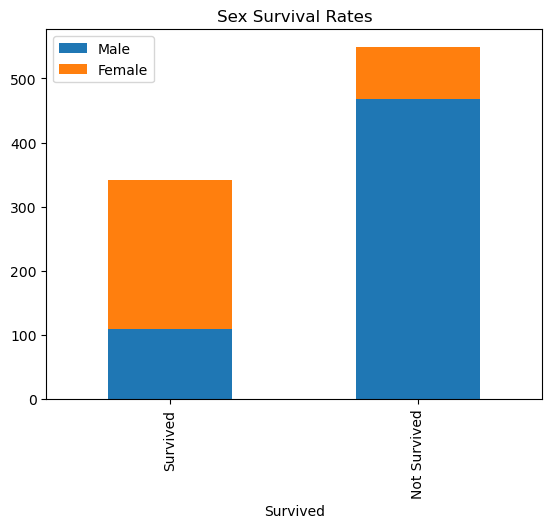

In [ ]:
# Let's plot the rates

ss = pd.DataFrame([['Survived', data_concat[data_concat['Sex']=='male'].Survived.value_counts()[1],
                    data_concat[data_concat['Sex']=='female'].Survived.value_counts()[1]],
                     ['Not Survived', data_concat[data_concat['Sex']=='male'].Survived.value_counts()[0],
                    data_concat[data_concat['Sex']=='female'].Survived.value_counts()[0]]],
                  columns=['Survived', 'Male', 'Female'])
# plot data in stack manner of bar type
ss.plot(x='Survived', kind='bar', stacked=True,
        title='Sex Survival Rates')
plt.show()

The plots speak for themselves. The Sex feature plays an important role on the prediction of survival.

In [ ]:
# Let's go to Pclass now

data_concat.Pclass.unique()

array([3, 1, 2])

In [ ]:
# The Survival percantages

data_concat.groupby('Pclass').Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

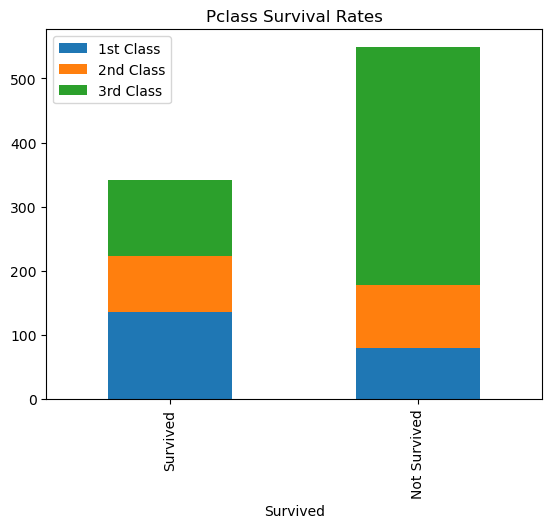

In [ ]:
sp = pd.DataFrame([['Survived', data_concat[data_concat['Pclass']==1].Survived.value_counts()[1],
                    data_concat[data_concat['Pclass']==2].Survived.value_counts()[1],
                    data_concat[data_concat['Pclass']==3].Survived.value_counts()[1]],
                     ['Not Survived', data_concat[data_concat['Pclass']==1].Survived.value_counts()[0],
                    data_concat[data_concat['Pclass']==2].Survived.value_counts()[0],
                      data_concat[data_concat['Pclass']==3].Survived.value_counts()[0]]],
                  columns=['Survived', '1st Class', '2nd Class', "3rd Class"])
# plot data in stack manner of bar type
sp.plot(x='Survived', kind='bar', stacked=True,
        title='Pclass Survival Rates')
plt.show()

In [ ]:
# The Survival percantages by Sex

data_concat.groupby(['Pclass', 'Sex']).Survived.mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

We see that Pclass itself and in combination with Sex can give us some more info, so we keep it as well.

Let's now investigate Fare and Cabin featues. These two features are strong and moderate correlation with negative association with Pclass, which we decided to keep for our prediction. So, I belive that Cabin feature would be more safe to keep for 2 reasons. One, because the cabins needed to be booked, so the data would not have missing values and the NaN values would be the passengers without a booked cabin. Second, is that fare is not so safe to keep because of the discounts, invitations and boarding location between the passengers, we could see this in the next plot, and we already chose to keep the Pclass information.

<AxesSubplot:xlabel='Sex', ylabel='Fare'>

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3544: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


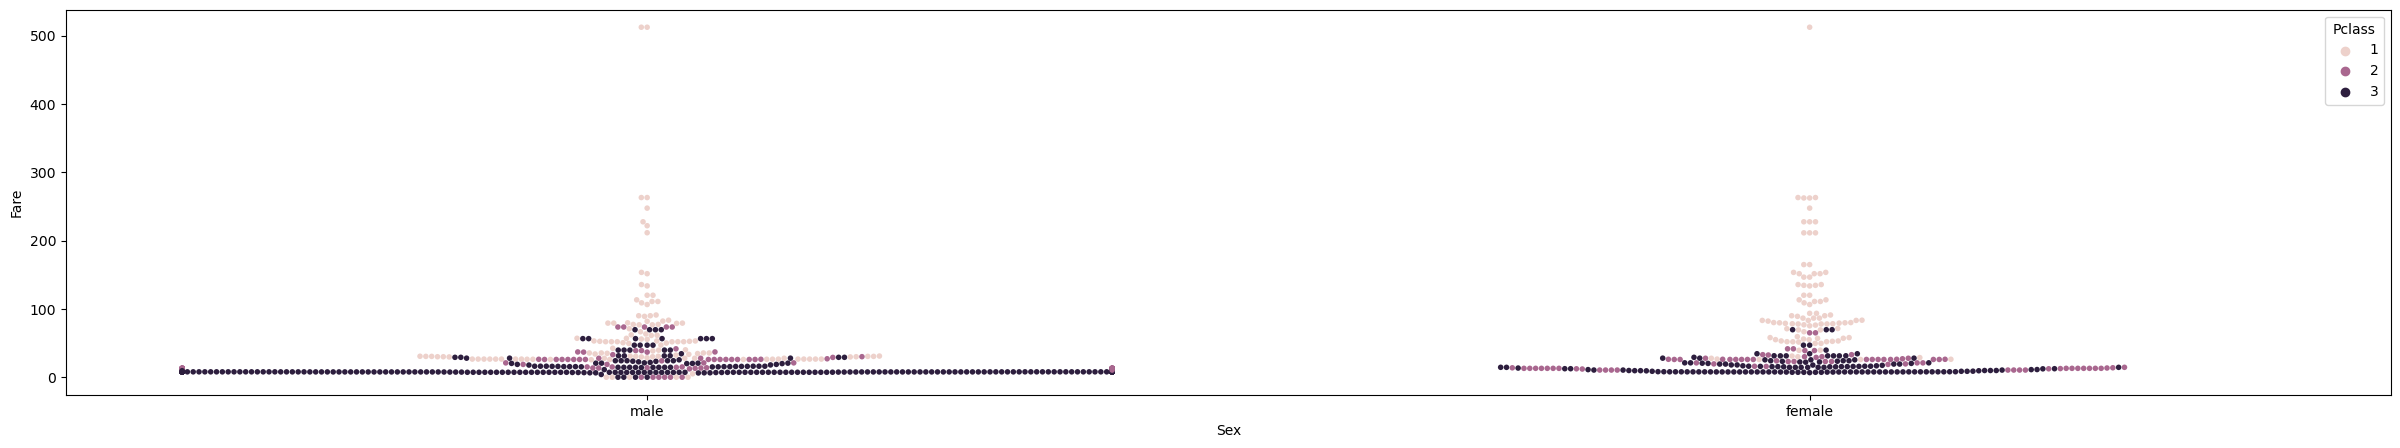

In [ ]:
# Let's see the negative association between Fare and Pclass

import seaborn as sns

plt.figure(figsize=(30,5))
sns.swarmplot(data=data_concat, x='Sex', y='Fare', hue='Pclass', native_scale=True,
              size=4)

In [ ]:
# Let's check the Cabin feature

data_concat.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [ ]:
# Let's replace the NaN values of the Cabin column with 'H' and the string values,
# that indicate a cabin, with the first letter that indicates the location of the cabin

data_concat.Cabin = data_concat.Cabin.replace({np.NaN : 'H'})
data_concat.loc[data_concat['Cabin'].str.contains('A', case=False), 'Cabin'] = 'A'
data_concat.loc[data_concat['Cabin'].str.contains('B', case=False), 'Cabin'] = 'B'
data_concat.loc[data_concat['Cabin'].str.contains('C', case=False), 'Cabin'] = 'C'
data_concat.loc[data_concat['Cabin'].str.contains('D', case=False), 'Cabin'] = 'D'
data_concat.loc[data_concat['Cabin'].str.contains('E', case=False), 'Cabin'] = 'E'
data_concat.loc[data_concat['Cabin'].str.contains('F', case=False), 'Cabin'] = 'F'
data_concat.loc[data_concat['Cabin'].str.contains('G', case=False), 'Cabin'] = 'G'
data_concat.loc[data_concat['Cabin'].str.contains('T', case=False), 'Cabin'] = 'T'

<AxesSubplot:xlabel='Sex', ylabel='Cabin'>

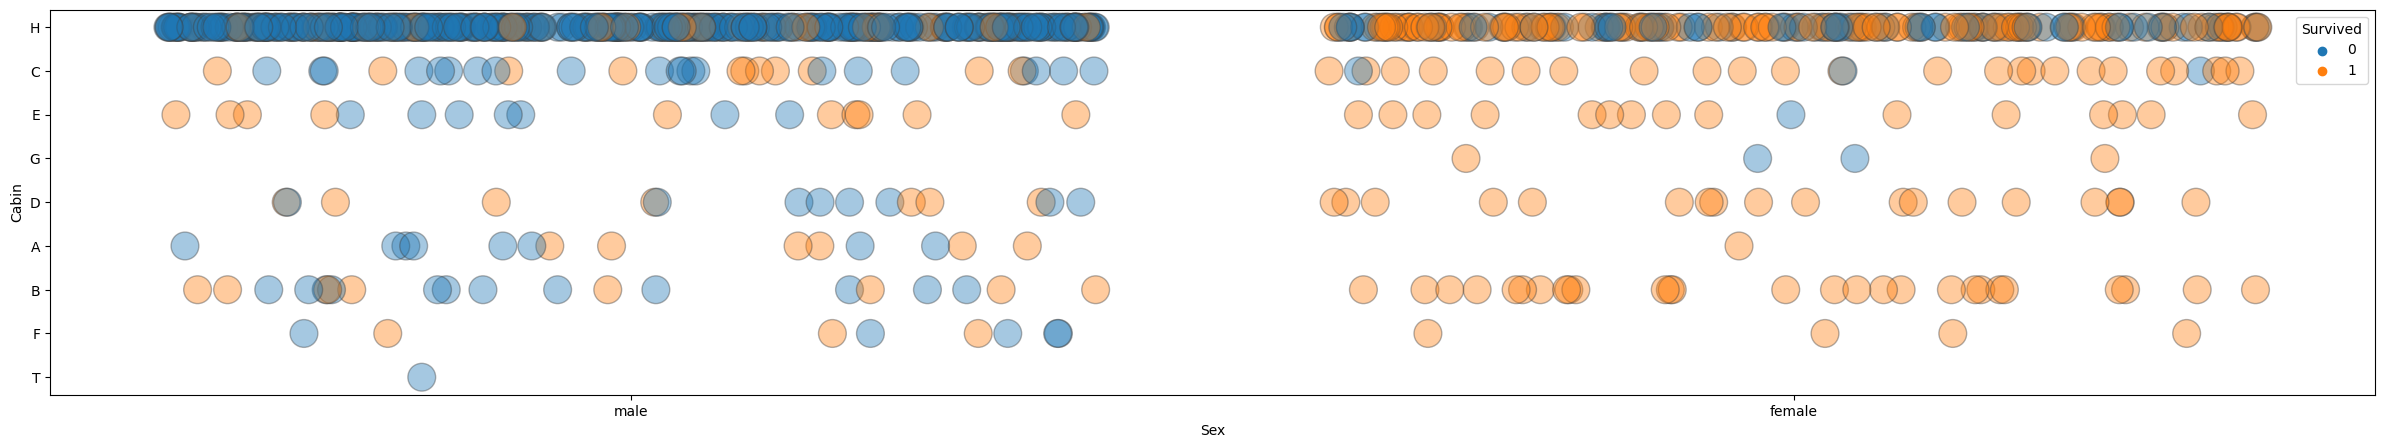

In [ ]:
plt.figure(figsize=(30,5))
sns.stripplot(data=data_concat, x='Sex', y='Cabin', hue='Survived',
              native_scale=True, s=20, linewidth=1, jitter=0.4,
              alpha=.4,)

In [ ]:
# The Survival percantages

data_concat.groupby(['Cabin', 'Sex']).Survived.mean()

Cabin  Sex   
A      female    1.000000
       male      0.428571
B      female    1.000000
       male      0.400000
C      female    0.888889
       male      0.343750
D      female    1.000000
       male      0.466667
E      female    0.937500
       male      0.588235
F      female    1.000000
       male      0.375000
G      female    0.500000
H      female    0.654378
       male      0.136170
T      male      0.000000
Name: Survived, dtype: float64

We can see that Cabin feature could gives us some extra help!

In [ ]:
# Let's deal with Embarkation now

data_concat.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [ ]:
data_concat.Embarked.value_counts().to_frame()

,Embarked
S,644
C,168
Q,77


In [ ]:
# We can see from the beggining that the passengers with NaN Embarkation are only 2

data_concat[data_concat.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B,NaN


In [ ]:
# Let's take care of the missing values

data_concat['Embarked'].fillna('S', inplace=True) # I will assigned these passengers to the "starting port", with the most embarkations

In [ ]:
label_encoder.classes_

array(['C', 'Q', 'S', nan], dtype=object)

<AxesSubplot:xlabel='Sex', ylabel='Embarked'>

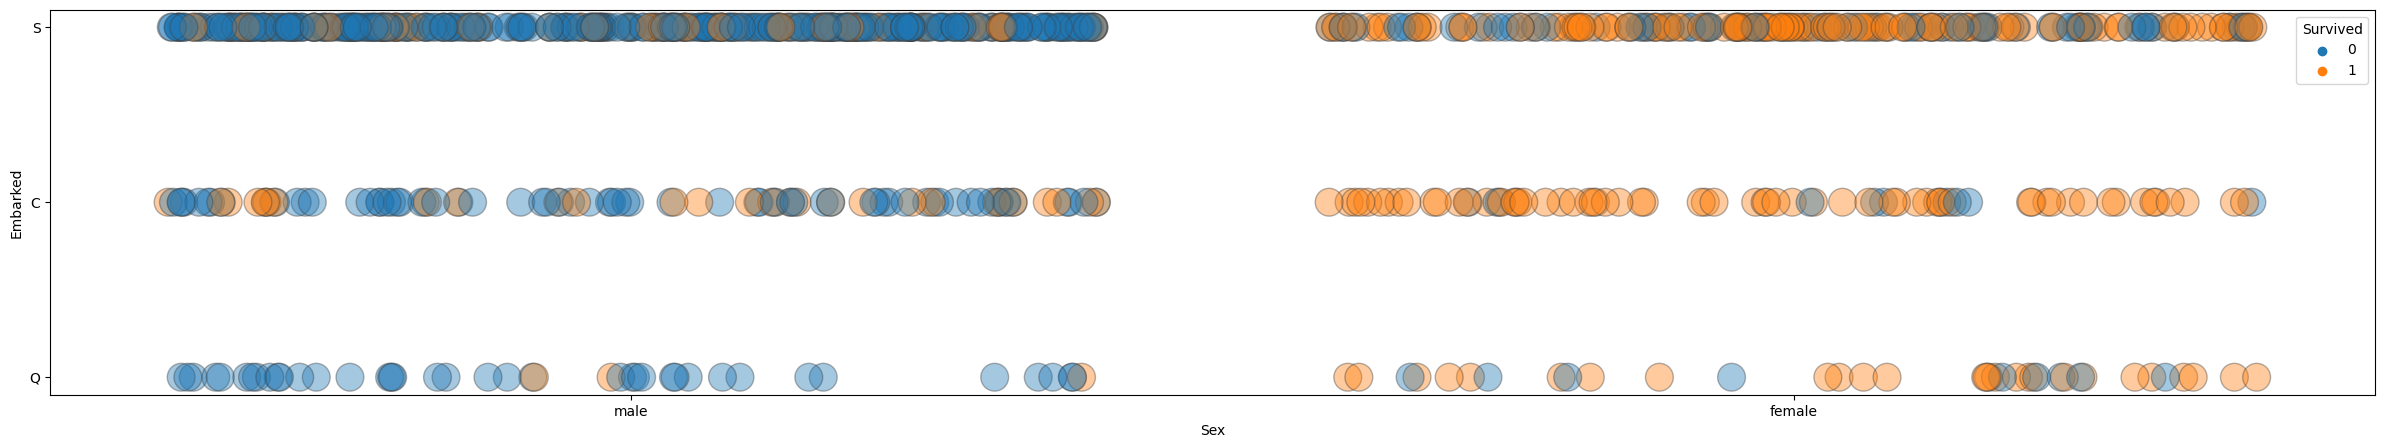

In [ ]:
# Let's plot to take an idea

plt.figure(figsize=(30,5))
sns.stripplot(data=data_concat, x='Sex', y='Embarked', hue='Survived',
              native_scale=True, s=20, linewidth=1, jitter=0.4,
              alpha=.4,)

In [ ]:
# Let's see the percentages, because the plot is not very clear

data_concat.groupby(['Embarked', 'Sex']).Survived.mean()

Embarked  Sex   
C         female    0.876712
          male      0.305263
Q         female    0.750000
          male      0.073171
S         female    0.692683
          male      0.174603
Name: Survived, dtype: float64

<AxesSubplot:xlabel='Sex', ylabel='Embarked'>

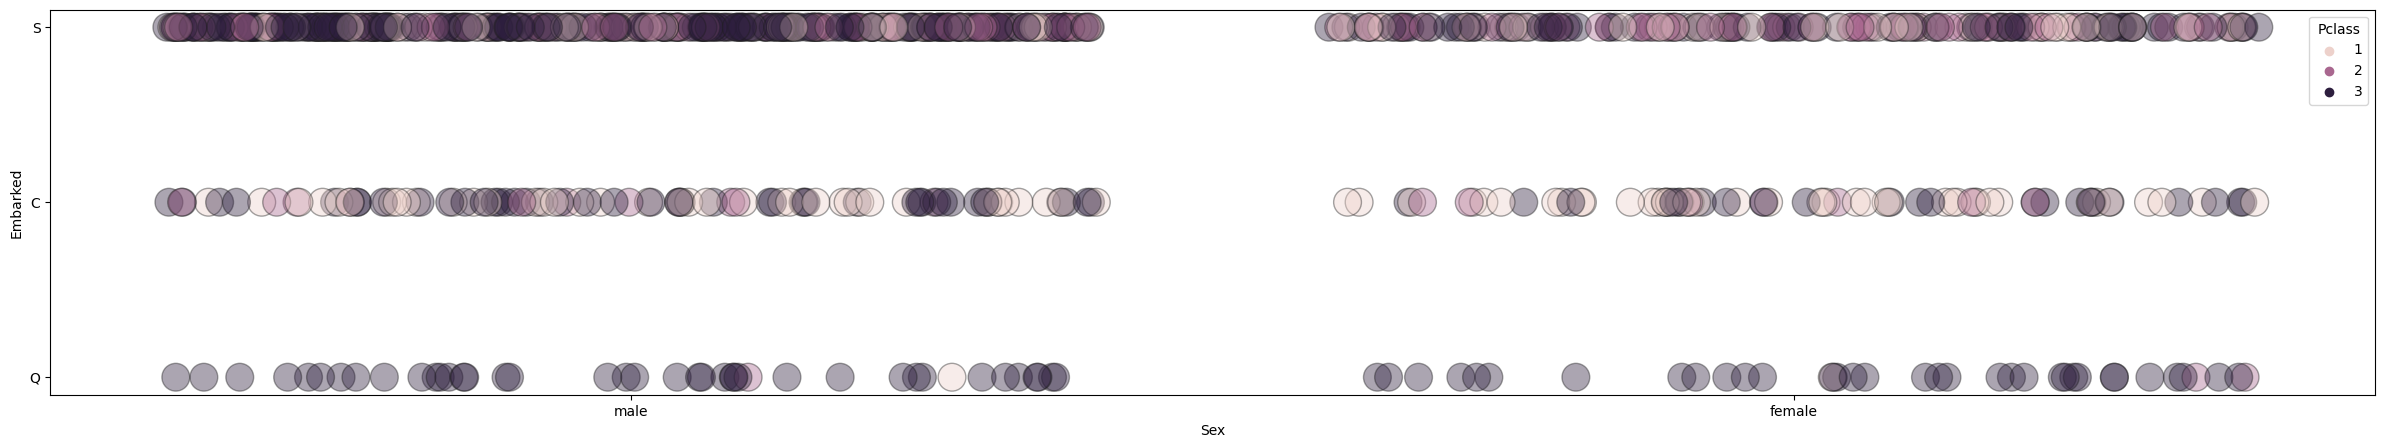

In [ ]:
plt.figure(figsize=(30,5))
sns.stripplot(data=data_concat, x='Sex', y='Embarked', hue='Pclass',
              native_scale=True, s=20, linewidth=1, jitter=0.4,
              alpha=.4,)

Above we can see the Pclass role in the survival percentages of the embarkation location. It seems that embarkation carries the information of the Pclass. Let's keep it for now and we will make a try without it later to see if it does help us.

In [ ]:
# Let's investigate the family status of the passengers, the sibsp and parch features

print(f"Range of Siblings/Spouses on board: {int(data_concat.SibSp.min())}-{int(data_concat.SibSp.max())}")
print(f"Range of Parents/Children on board: {int(data_concat.Parch.min())}-{int(data_concat.Parch.max())}")

Range of Siblings/Spouses on board: 0-8
Range of Parents/Children on board: 0-6


In [ ]:
# The Survival percantages by Sex and Siblings/Spouses

data_concat.groupby(['SibSp', 'Sex']).Survived.mean()

SibSp  Sex   
0      female    0.787356
       male      0.168203
1      female    0.754717
       male      0.310680
2      female    0.769231
       male      0.200000
3      female    0.363636
       male      0.000000
4      female    0.333333
       male      0.083333
5      female    0.000000
       male      0.000000
8      female    0.000000
       male      0.000000
Name: Survived, dtype: float64

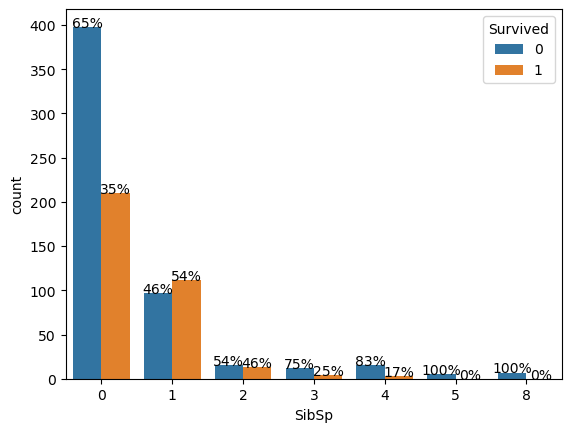

In [ ]:
# Let's plot the rates

ax = sns.countplot(data=data_concat, x='SibSp', hue='Survived')

bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    ax.text(left.get_x() + left.get_width()/2., height_l, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r, '{0:.0%}'.format(height_r/total), ha="center")

plt.show()

The data do not say a clear story, but I can see that combined with Sex could help on the predictions.

In [ ]:
# The Survival percantages by Sex and Parents/Children

data_concat.groupby(['Parch', 'Sex']).Survived.mean()

Parch  Sex   
0      female    0.788660
       male      0.165289
1      female    0.766667
       male      0.327586
2      female    0.612245
       male      0.322581
3      female    0.750000
       male      0.000000
4      female    0.000000
       male      0.000000
5      female    0.250000
       male      0.000000
6      female    0.000000
Name: Survived, dtype: float64

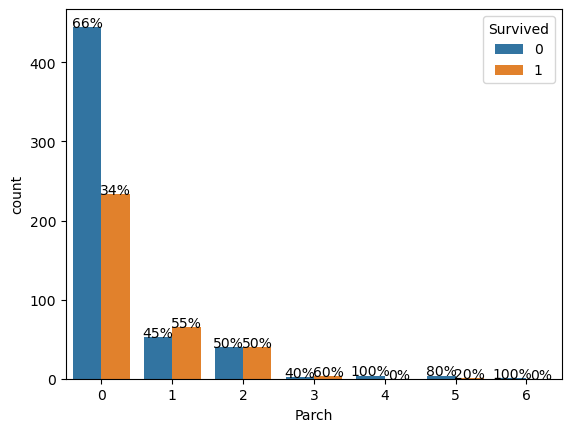

In [ ]:
# Let's plot the rates

ax = sns.countplot(data=data_concat, x='Parch', hue='Survived')

bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    ax.text(left.get_x() + left.get_width()/2., height_l, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r, '{0:.0%}'.format(height_r/total), ha="center")

plt.show()

Now I see that in both cases the survival rate is more that 50% in 1, 2 and 3, which is very interesting. Small families have more chances, so let's put these two features together and create a new one "family_size".

In [ ]:
data_concat['FamilySize'] = data_concat['SibSp'] + data_concat['Parch'] + 1 # Starting with 1, as "alone"
data_concat.drop(['SibSp', 'Parch'], inplace = True, axis = 1)

In [ ]:
# Let's check the Tickets really fast

data_concat.Ticket.head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

In [ ]:
# The Survival percantages by Ticket

data_concat['Ticket_2letters'] = data_concat['Ticket'].apply(lambda x: x[:2])
data_concat.groupby(['Ticket_2letters']).Survived.mean()

Ticket_2letters
11    0.568182
12    0.500000
13    0.727273
14    0.750000
16    0.800000
17    0.769231
19    0.687500
20    1.000000
21    0.000000
22    0.666667
23    0.444444
24    0.551724
25    0.500000
26    0.416667
27    0.750000
28    0.166667
29    0.642857
31    0.243243
32    0.000000
33    0.562500
34    0.143939
35    0.296296
36    0.347826
37    0.240000
38    0.200000
39    0.600000
41    0.222222
45    0.000000
54    0.000000
57    0.000000
65    0.250000
69    0.000000
72    0.000000
75    0.125000
84    0.000000
92    1.000000
A.    0.000000
A/    0.083333
A4    0.000000
C     0.400000
C.    0.464286
CA    0.071429
F.    0.666667
Fa    0.000000
LI    0.250000
P/    0.500000
PC    0.650000
PP    0.666667
S.    0.142857
SC    0.500000
SO    0.166667
ST    0.444444
SW    1.000000
W.    0.100000
W/    0.000000
WE    0.500000
Name: Survived, dtype: float64

We could give it a try latter with our model.

<AxesSubplot:xlabel='Sex', ylabel='Age'>

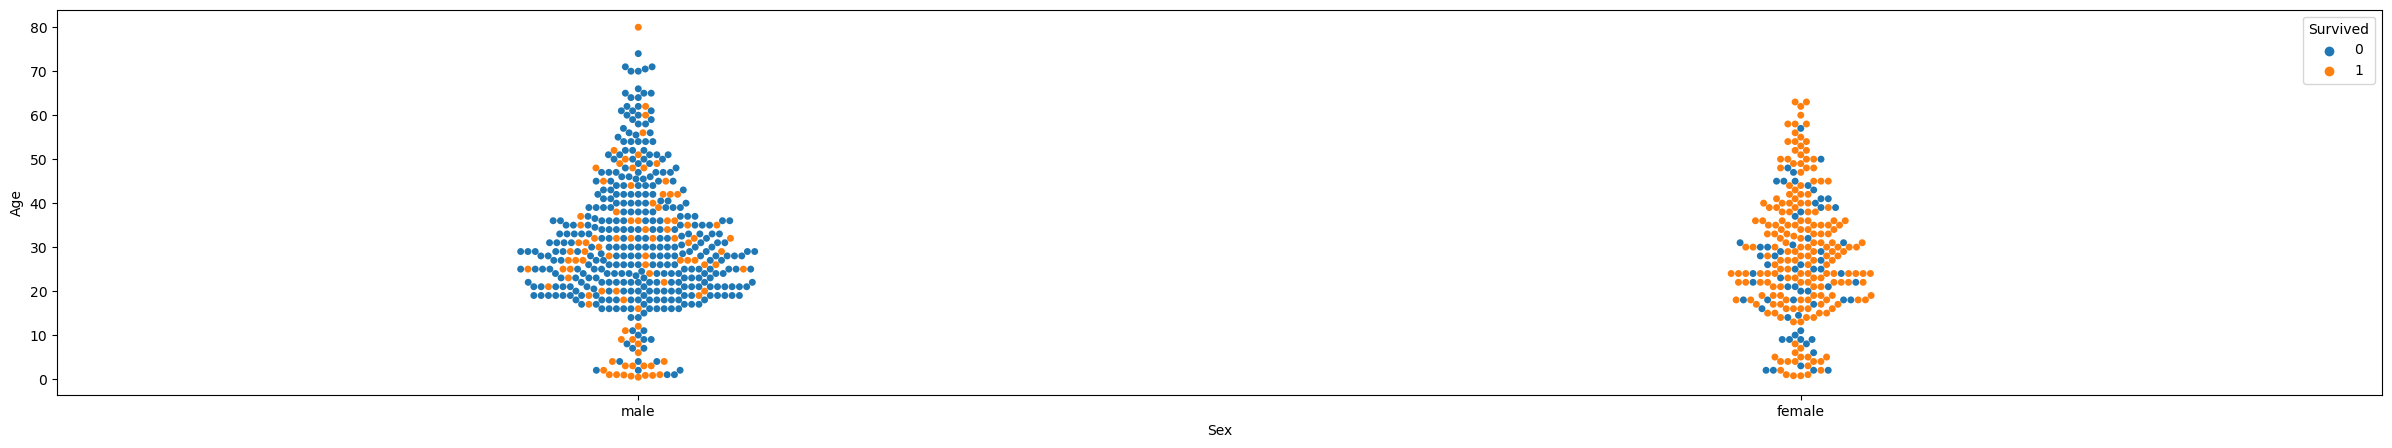

In [ ]:
# And now let's "touch" the Age feature

# We have many missing values and we need to decide how we are gonig to deal
# with those.

# Let's see the negative association between Fare and Pclass

plt.figure(figsize=(30,5))
sns.swarmplot(data=data_concat, x='Sex', y='Age', hue='Survived', native_scale=True,
              size=5)

The really young male passengers have a good chance of surviving and the really old ones as well. Though the information in between that the Age feature give us is not really helpfull. So, regarding the missing values, it is important to find out who could be less that 10 years old. Let's try!

In [ ]:
# The passengers who are less the 10 years old

data_concat[data_concat.Age<10]

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize,Ticket_2letters
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,349909,21.0750,H,S,5,34
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,PP 9549,16.7000,G,S,3,PP
16,17,0,3,"Rice, Master. Eugene",male,2.00,382652,29.1250,H,Q,6,38
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.00,349909,21.0750,H,S,5,34
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.00,SC/Paris 2123,41.5792,H,C,4,SC
...,...,...,...,...,...,...,...,...,...,...,...,...
827,828,1,2,"Mallet, Master. Andre",male,1.00,S.C./PARIS 2079,37.0042,H,C,3,S.
831,832,1,2,"Richards, Master. George Sibley",male,0.83,29106,18.7500,H,S,3,29
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.00,347082,31.2750,H,S,7,34
852,853,0,3,"Boulos, Miss. Nourelain",female,9.00,2678,15.2458,H,C,3,26


In [ ]:
print(f"The maximum age for the Misses on board is: {data_concat.Age[data_concat.Name.str.contains('Miss', case=False)].max()}")
print(f"The maximum age for the Masters on board is: {data_concat.Age[data_concat.Name.str.contains('Master', case=False)].max()}")

The maximum age for the Misses on board is: 63.0
The maximum age for the Masters on board is: 12.0


I can see that for the young male passengers the title "Master" is used and the title "Miss" is used most probably for the unmarried Ladies and girls.

In [ ]:
count_misses = data_concat.Name[data_concat.Age.isna()].str.contains('Miss', case=False).sum()
count_masters = data_concat.Name[data_concat.Age.isna()].str.contains('Master', case=False).sum()
print(f"The Misses with the missing age are: {count_misses}")
print(f"The Masters with the missing age are: {count_masters}")

The Misses with the missing age are: 36
The Masters with the missing age are: 4


We see a two digits number for the female passengers with missing Age information (which is not usefull, we are more intresting to the male passsengers) and only one male passenger. So, I will investigated a little bit more the age feature.

In [ ]:
# Let's see the medians for the different sexes and classes

age_by_pclass_sex = data_concat.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {} '.format(pclass, sex, age_by_pclass_sex[sex][pclass].astype(int)))

Median age of Pclass 1 females: 35 
Median age of Pclass 1 males: 40 
Median age of Pclass 2 females: 28 
Median age of Pclass 2 males: 30 
Median age of Pclass 3 females: 21 
Median age of Pclass 3 males: 25 


In [ ]:
# So, let's fill the missing age values with median of each Pclass and Sex,
# the same for the "Misses" too and just with the median for our little "Masters"

data_concat.loc[data_concat['Name'].str.contains('Master', case=False) & data_concat['Age'].isna(), 'Age'] = data_concat.Age[data_concat['Name'].str.contains('Master', case=False)].median()
for i in range(1, 4):
    data_concat.loc[data_concat['Name'].str.contains('Miss', case=False) & (data_concat['Pclass']==i) & data_concat['Age'].isna(), 'Age'] = data_concat.Age[data_concat['Name'].str.contains('Miss', case=False) & (data_concat['Pclass']==i)].median()
    data_concat.loc[(data_concat['Sex']=='male') & (data_concat['Pclass']==i) & (data_concat['Age'].isna()), 'Age'] = data_concat.Age[(data_concat['Sex']=='male') & (data_concat['Pclass']==i)].median()
    data_concat.loc[(data_concat['Sex']=='female') & (data_concat['Pclass']==i) & (data_concat['Age'].isna()), 'Age'] = data_concat.Age[(data_concat['Sex']=='female') & (data_concat['Pclass']==i)].median()

In [ ]:
# Now we are going to check if all the missing values have been filled

print(data_concat.isnull().sum())
print(data_concat.shape)

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age                0
Ticket             0
Fare               0
Cabin              0
Embarked           0
FamilySize         0
Ticket_2letters    0
dtype: int64
(891, 12)


In [ ]:
# I will prepare on more feature that maybe could help, that of the passenger's title

data_concat['Title'] = data_concat['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [ ]:
# The Survival percantages by Title

data_concat.groupby('Title').Survived.mean()

Title
Capt            0.000000
Col             0.500000
Don             0.000000
Dr              0.428571
Jonkheer        0.000000
Lady            1.000000
Major           0.500000
Master          0.575000
Miss            0.697802
Mlle            1.000000
Mme             1.000000
Mr              0.156673
Mrs             0.792000
Ms              1.000000
Rev             0.000000
Sir             1.000000
the Countess    1.000000
Name: Survived, dtype: float64

With the "Title" feature we could set aside the "Age" feature, which is not so helpful as we saw from the plots above. So, we will try to replace "Sex" and "Age" with "Title" and see what happens.

--------------------------------------------

In [ ]:
# Let's choose the features, after many trials

final_trn_data = data_concat.copy()
y_train = data_concat.Survived.copy()
    
features = ["Pclass", "Title", "Embarked", "Fare", "Ticket", "Cabin", "FamilySize"]

final_trn_data = final_trn_data[features]

In [ ]:
# Preparation of the Test Data

# Fare
for i in range(1,4):
    final_trn_data.loc[(final_trn_data['Pclass']==i) & (final_trn_data['Fare'].isna()), 'Fare'] = data_concat.Fare[data_concat['Pclass']==i].median()

# Embarked
test_data['Embarked'].fillna('S', inplace=True)

# Cabin
test_data.Cabin = test_data.Cabin.replace({np.NaN : 'H'})
test_data.loc[test_data['Cabin'].str.contains('A', case=False), 'Cabin'] = 'A'
test_data.loc[test_data['Cabin'].str.contains('B', case=False), 'Cabin'] = 'B'
test_data.loc[test_data['Cabin'].str.contains('C', case=False), 'Cabin'] = 'C'
test_data.loc[test_data['Cabin'].str.contains('D', case=False), 'Cabin'] = 'D'
test_data.loc[test_data['Cabin'].str.contains('E', case=False), 'Cabin'] = 'E'
test_data.loc[test_data['Cabin'].str.contains('F', case=False), 'Cabin'] = 'F'
test_data.loc[test_data['Cabin'].str.contains('G', case=False), 'Cabin'] = 'G'
test_data.loc[test_data['Cabin'].str.contains('T', case=False), 'Cabin'] = 'T'

# Family size
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1 # Starting with 1, as "alone"
test_data.drop(['SibSp', 'Parch'], inplace = True, axis = 1)

# Title
test_data['Title'] = test_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())


final_test_data = test_data[features].copy()

In [ ]:
final_test_data.head(1)

,Pclass,Title,Embarked,Fare,Ticket,Cabin,FamilySize
0,3,Mr,Q,7.8292,330911,H,1


I am using CatBoostClassifier, after many trials with RandomForestClassifier, HistGradientBoostingClassifier, SVC and AdaBoostClassifier. 
Voting method has been used as well. CatBoostClassifier was very convinient as no extra preparation for the data was needed. For the rest 
I had to use LabelEncoder and OneHotEncoder in order to run them.

In [ ]:
# The model

from catboost import CatBoostClassifier

cat_features = [1, 2, 4, 5]

model = CatBoostClassifier(iterations=70, learning_rate=0.05, feature_weights=[1],
                           cat_features=cat_features, random_state=42)

model.fit(final_trn_data, y_train)

print(model.score(final_trn_data, y_train))

0:	learn: 0.6745860	total: 61.1ms	remaining: 4.21s
1:	learn: 0.6570485	total: 63.2ms	remaining: 2.15s
2:	learn: 0.6414827	total: 65.2ms	remaining: 1.46s
3:	learn: 0.6269144	total: 66.1ms	remaining: 1.09s
4:	learn: 0.6134452	total: 67.8ms	remaining: 882ms
5:	learn: 0.5993411	total: 70ms	remaining: 747ms
6:	learn: 0.5859602	total: 71.4ms	remaining: 642ms
7:	learn: 0.5741381	total: 72.5ms	remaining: 561ms
8:	learn: 0.5644780	total: 73.2ms	remaining: 496ms
9:	learn: 0.5545102	total: 74.5ms	remaining: 447ms
10:	learn: 0.5454830	total: 75.9ms	remaining: 407ms
11:	learn: 0.5371568	total: 76.7ms	remaining: 370ms
12:	learn: 0.5291581	total: 78.5ms	remaining: 344ms
13:	learn: 0.5222776	total: 79.1ms	remaining: 316ms
14:	learn: 0.5158055	total: 80.2ms	remaining: 294ms
15:	learn: 0.5090380	total: 81.3ms	remaining: 274ms
16:	learn: 0.5027977	total: 82.3ms	remaining: 257ms
17:	learn: 0.4967066	total: 83.5ms	remaining: 241ms
18:	learn: 0.4907527	total: 84.5ms	remaining: 227ms
19:	learn: 0.4855355	tot

In [ ]:
predictions = model.predict(final_test_data)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [ ]:
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
